In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import retentioneering
import numpy as np
import os,sys,inspect
import datetime
from copy import deepcopy, copy
from calendar import monthrange
from tqdm.auto import tqdm, trange
import scipy.stats as st
import matplotlib.pyplot as plt
import pickle

import warnings
import seaborn as sns; sns.set_style('whitegrid')
import matplotlib.gridspec as gridspec
import re
import time

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from collections import Counter
from IPython.display import clear_output
import networkx as nx

import IPython
import io

In [2]:
def cut_conversion(data,target_event,keep_target=False):
    data_cut = data.copy()
    data_cut['was_conversion'] = 0
    data_cut.loc[data_cut.event==target_event,'was_conversion'] = 1
    data_cut['was_conversion'] = data_cut.groupby('client_id').was_conversion.cumsum()
    
    if keep_target:
        data_cut.loc[data_cut.event==target_event,'was_conversion'] = 0
    
    data_cut = data_cut[data_cut.was_conversion == 0]
    data_cut['dist_to_target'] = np.inf
    mask = data_cut.client_id.isin(data_cut[data_cut.event==target_event].client_id.unique())
    data_cut.loc[mask,'dist_to_target'] = data_cut.loc[mask].groupby('client_id').dist_to_target.cumcount(ascending=False)
    data_cut.sort_values('global_idx',inplace=True)
    return data_cut

def link_corpus_cjm(corpus):
    corpus = corpus.reset_index()
    corpus.event = corpus.event.apply(lambda x: '~~'.join([el.lower() for el in x]))
    return corpus

def prepare_for_clustering(session_corpus, col='session', ngram_range=(1,1), flag_session_list=[],flags_enumerate=[],insert_flags=False):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, token_pattern='[^~]+').fit(session_corpus.event)
    vocab_with_flags = vectorizer.vocabulary_
    if insert_flags:
        flags = [f'flag_{x}' for x in flags_enumerate.keys()]
        vocab_with_flags.update({flag: ind for ind, flag in enumerate(flags)})
        vocab_with_flags = {val: ind for ind, val in enumerate(vocab_with_flags.keys())}
        # Appending flags to sessions
        for key, val in flag_session_list.items():
            session_corpus.loc[session_corpus[col].isin(val), 'event'] = \
                session_corpus.loc[session_corpus[col].isin(val), 'event'].apply(lambda x: x + f'~~flag_{key}')

    vectorizer = TfidfVectorizer(vocabulary=vocab_with_flags,
                                 token_pattern='[^~]+')
    tfidf = pd.DataFrame(index=session_corpus[col].values,
                         data=vectorizer.fit_transform(session_corpus.event).todense())
    tfidf.columns = vectorizer.get_feature_names()
    return tfidf

normalize = lambda x: x / sum(x)

%matplotlib inline

## Preparing data

In [3]:
res = pd.read_csv('10_practice_dataset.csv',sep=',')
res.head()

,client_id,session,timestamp,event
0,100387706708393501,1003877067083935011579908637,2020-01-24 23:30:37,/catalog
1,100387706708393501,1003877067083935011579908637,2020-01-26 08:12:40,/catalog
2,100387706708393501,1003877067083935011579908637,2020-01-26 10:53:29,/catalog
3,100387706708393501,1003877067083935011579908637,2020-01-26 11:49:41,/catalog
4,100387706708393501,1003877067083935011579908637,2020-01-27 01:06:18,/catalog


In [4]:
res['event'].value_counts()

/catalog                    81357
/cart                        5495
/main                        3902
/search                      3882
buyButton                    3795
click_goToCart               2867
Checkout_PaymentDelivery     2855
global_lost                  2349
CheckoutInstallment          1354
click_Product                1054
purchase                      703
click_buyButton               519
Refund                          1
Name: event, dtype: int64

In [5]:
#обновление словаря retentioneering.config в соответствии с названиями колонок в нашем датафрейме
retentioneering.config.update({
    'event_col':'event',
    'event_time_col':'timestamp',
    'user_col': 'client_id',
})

In [6]:
res_rete = res.sort_values(['client_id','timestamp'])
res_rete['next_event'] = \
         res_rete.groupby('session').event.shift(-1).fillna('end_of_session')
res_rete['global_idx'] = np.arange(res_rete.shape[0])
res_rete['client_idx'] = res_rete.groupby('client_id').cumcount()
res_rete.head()

,client_id,session,timestamp,event,next_event,global_idx,client_idx
71967,640282419644438,6402824196444381580058645,2020-01-26 17:10:45,/main,/catalog,0,0
71968,640282419644438,6402824196444381580059692,2020-01-26 17:28:12,/main,/catalog,1,1
71969,640282419644438,6402824196444381580058645,2020-01-26 19:37:48,/catalog,/catalog,2,2
71970,640282419644438,6402824196444381580059392,2020-01-26 20:04:53,/main,/main,3,3
71971,640282419644438,6402824196444381580058645,2020-01-26 21:59:16,/catalog,/catalog,4,4


## Predicting conversion

In [7]:
print(f"Mean session length: {round(res_rete.groupby('client_id').event.count().mean())}")

Mean session length: 40


In [8]:
#Cut target_events
res_rete_cut = cut_conversion(res_rete.sort_values(['client_id','timestamp']),'purchase')
idx_dict = res_rete_cut.groupby('client_id').client_idx.max().to_dict()
res_rete_cut['max_idx'] = (res_rete_cut.client_id.map(idx_dict) - 20).apply(lambda x: x if x > 0 else 0)
selected = res_rete_cut[res_rete_cut.max_idx > 0]
selected.head()

,client_id,session,timestamp,event,next_event,global_idx,client_idx,was_conversion,dist_to_target,max_idx
71967,640282419644438,6402824196444381580058645,2020-01-26 17:10:45,/main,/catalog,0,0,0,inf,22
71968,640282419644438,6402824196444381580059692,2020-01-26 17:28:12,/main,/catalog,1,1,0,inf,22
71969,640282419644438,6402824196444381580058645,2020-01-26 19:37:48,/catalog,/catalog,2,2,0,inf,22
71970,640282419644438,6402824196444381580059392,2020-01-26 20:04:53,/main,/main,3,3,0,inf,22
71971,640282419644438,6402824196444381580058645,2020-01-26 21:59:16,/catalog,/catalog,4,4,0,inf,22


In [9]:
#Cut last 20 events
selected = selected[(selected.client_idx <= selected.max_idx)]
print(f"Fraction of users with session length >= 20: {selected.client_id.nunique()/res_rete_cut.client_id.nunique()}")

Fraction of users with session length >= 20: 0.9323984178353111


In [10]:
#Sanity check - last 20 events are cut
res_rete[res_rete.client_id==100387706708393501].client_idx.max() - \
    selected[selected.client_id==100387706708393501].client_idx.max()

20

In [11]:
#No target events are in data
selected[selected.event.isin(['global_lost','purchase'])].shape

(0, 10)

In [12]:
#Mapping users
good_users = res_rete[res_rete.event=='purchase'].client_id.unique()
bad_users = res_rete[~res_rete.client_id.isin(good_users)].client_id.unique()

In [13]:
#Making CJM and applying vectorization
client_corpus = selected.groupby('client_id')['event'].apply(
        lambda x: np.array([l.lower() for l in x]))

linked_client_corpus = link_corpus_cjm(client_corpus)
tfidf_clustering = prepare_for_clustering(linked_client_corpus.copy(),col='client_id',insert_flags=False)
X = tfidf_clustering
y = [1 if t else 0 for t in tfidf_clustering.index.isin(good_users)]

C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Clustering

### After data cut

In [14]:
from sklearn.cluster import KMeans
#from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

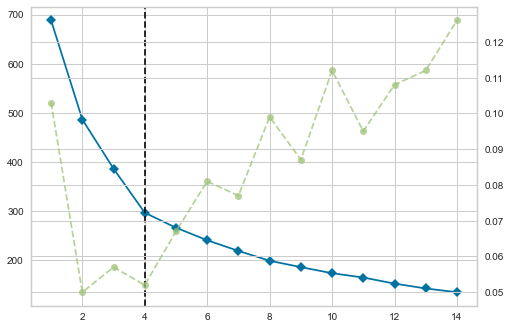

In [15]:
visualizer = KElbowVisualizer(
    KMeans(random_state=41), k=(1,15),locate_elbow=True
)
good_val = visualizer.fit(tfidf_clustering)

C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


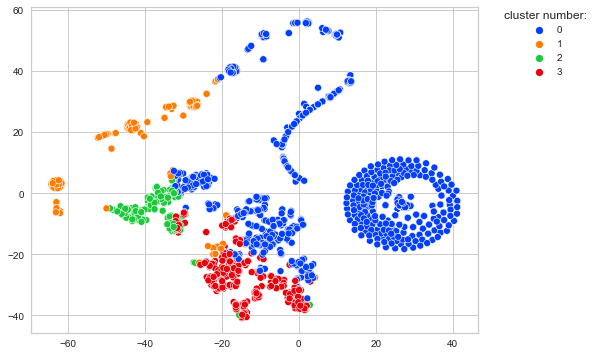

In [16]:
selected.rete.get_clusters(n_clusters=4)
selected.rete.project(method='tsne', plot_type='clusters');

**Вопрос 1**
Проведите кластеризацию пользователей. Ответьте, какое число кластеров оптимально и почему. Обоснуйте ответ.
* Алгоритмы кластеризации принимают на вход матрицы чисел, у вас же в данных последовательность событий, заданных строками. Как можно векторизовать эту информацию для дальнейшей работы?
* Какие есть метрики для определения оптимального количества кластеров? Например, для KMeans.

**Ответ:**
1. График показывает, насколько точки изолированы по краям. Для наглядности взяты 15 кластеров. Перегиб виден в 4 кластере, поэтому это число оптимально для дальнейшего анализа
2. Алгоритмы кластеризации принимают на вход матрицы чисел, в данных последовательность событий, заданных строками. Векторизовать эту информацию для дальнейшей работы можно через ID пользователей, завязанных на события, или сессии
3. Какие есть метрики для определения оптимального количества кластеров? 
* Метод локтя (подразумевает многократное циклическое исполнение алгоритма с увеличением количества выбираемых кластеров, а также последующим откладыванием на графике балла кластеризации, вычисленного как функция от количества кластеров), 
* Силуэт (Коэффициент «силуэт» вычисляется с помощью среднего внутрикластерного расстояния (a) и среднего расстояния до ближайшего кластера (b) по каждому образцу. Силуэт вычисляется как (b - a) / max(a, b).  b — это расстояние между a и ближайшим кластером, в который a не входит. Можно вычислить среднее значение силуэта по всем образцам и использовать его как метрику для оценки количества кластеров)
* Оценка BIC с моделью смеси нормальных распределений (байесовский информационный критерий (BIC). Но их можно применять лишь в том случае, если нам нужно перейти от метода k-средних к более обобщённой версии — смеси нормальных распределений (Gaussian Mixture Model (GMM))

### Before data cut

In [17]:
full_client_corpus = res_rete.groupby('client_id')['event'].apply(
        lambda x: np.array([l.lower() for l in x]))

full_linked_client_corpus = link_corpus_cjm(full_client_corpus)
full_tfidf = prepare_for_clustering(full_linked_client_corpus.copy(),col='client_id',insert_flags=False)

C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CPU times: total: 7.02 s
Wall time: 784 ms


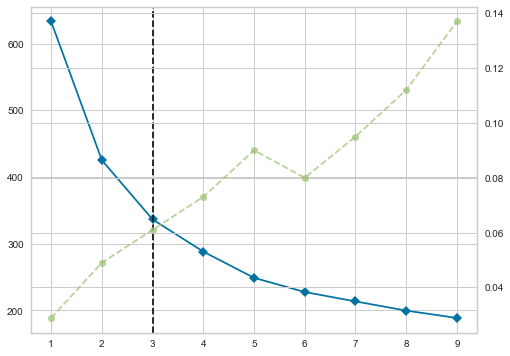

In [18]:
%%time
visualizer = KElbowVisualizer(
    KMeans(random_state=42), k=(1,10),locate_elbow=True
)
good_val = visualizer.fit(full_tfidf)

В данных до обрезки сохраняются теже тенденции поведения кластеров, но переломным является 3 кластер

C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


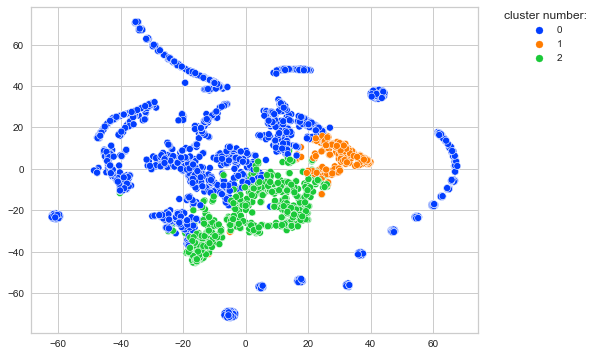

In [19]:
res_rete.rete.get_clusters(n_clusters=3)
res_rete.rete.project(method='tsne', plot_type='clusters');

C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


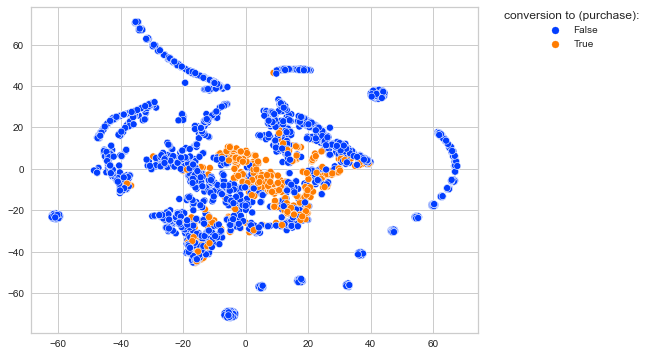

In [20]:
res_rete.rete.project(method='tsne', plot_type='targets', targets=['purchase']);

In [21]:
#обновление словаря retentioneering.config в соответствии с названиями колонок в нашем датафрейме
retentioneering.config.update({
    'event_col': 'event',
    'event_time_col': 'timestamp',
    'user_col': 'client_id',
})

In [22]:
res_rete.rete.plot_graph(
                     norm_type=None,
                     targets={'purchase':'green',
                              'global_lost':'red',
                              
                               },
                     thresh=30,
                    );

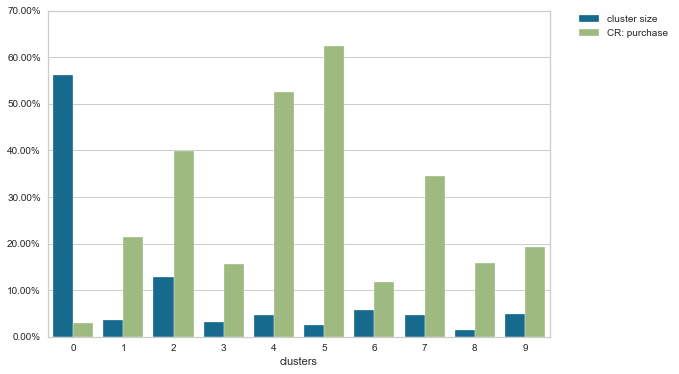

In [23]:
res_rete.rete.get_clusters(plot_type='cluster_bar', 
                       n_clusters=10, 
                       ngram_range=(1,1),
                       targets=['purchase']
                      );

In [24]:
#самый конверсионный кластер
res_rete.rete.filter_cluster(4).rete.plot_graph(
                     norm_type=None,
                     targets={'purchase':'green',
                              'global_lost':'red',
                              
                               },
                     thresh=30,
                    );

In [25]:
res_rete.rete.filter_cluster(5).rete.plot_graph(
                     norm_type=None,
                     targets={'purchase':'green',
                              'global_lost':'red',
                              
                               },
                     thresh=30,
                    );

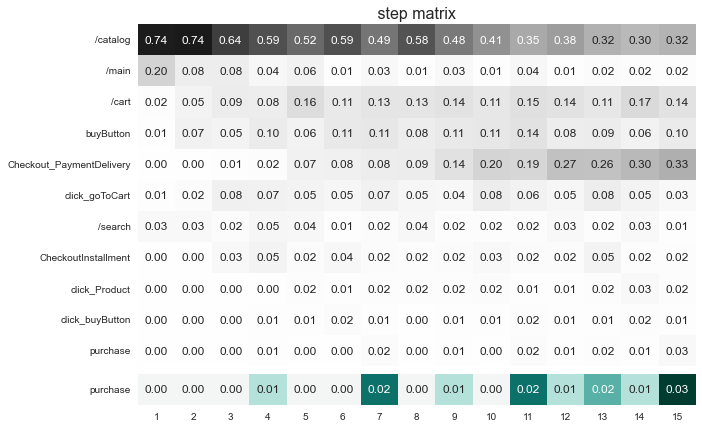

In [26]:
step_matrix = res_rete.rete.filter_cluster(4).rete.step_matrix(max_steps=15,
                                  targets=['purchase'])

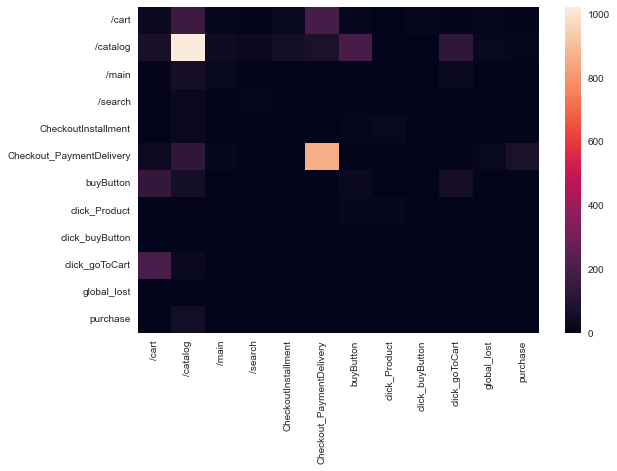

In [27]:
sns.heatmap(res_rete.rete.filter_cluster(4).rete.get_adjacency());

C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\retentioneering\core\core_functions\get_clusters.py:232: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_all.append(top_cluster, ignore_index=True, sort=False),


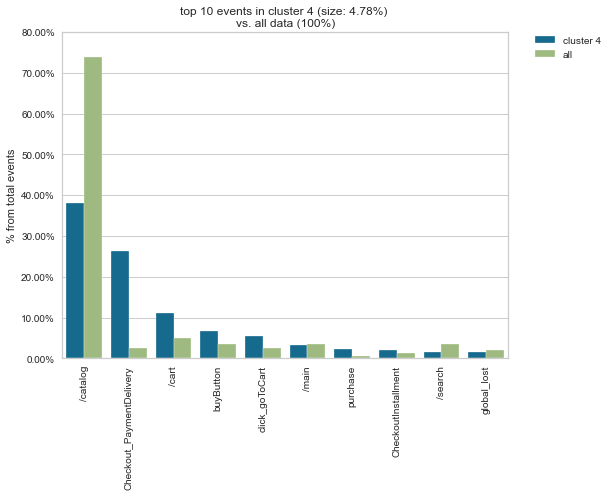

In [28]:
res_rete.rete.cluster_event_dist(4, top_n=10)

In [29]:
#наименее конверсионный кластер
res_rete.rete.filter_cluster(0).rete.plot_graph(
                     norm_type=None,
                     targets={'purchase':'green',
                              'global_lost':'red',
                              
                               },
                     thresh=30,
                    );

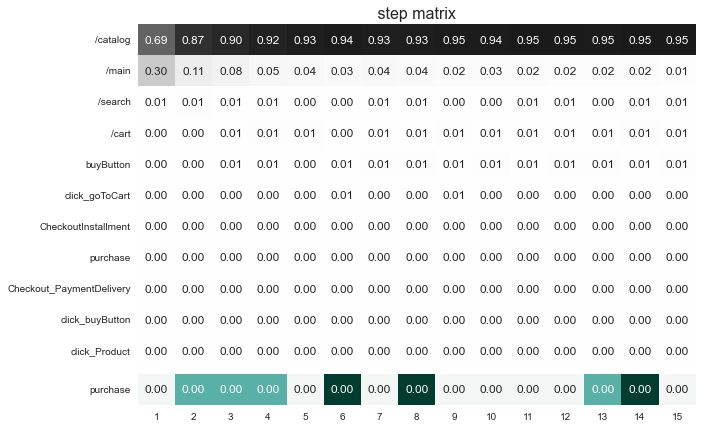

In [30]:
step_matrix = res_rete.rete.filter_cluster(0).rete.step_matrix(max_steps=15,
                                  targets=['purchase'])

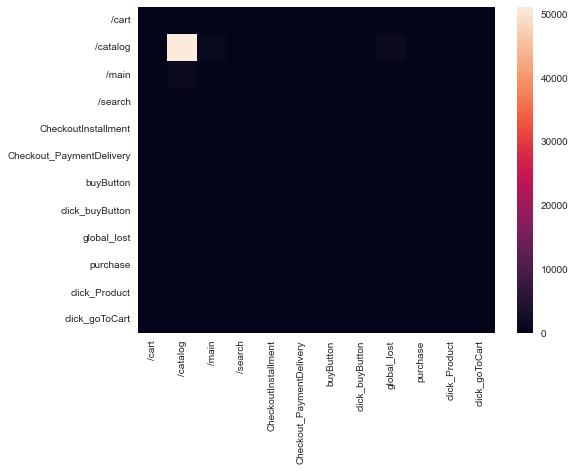

In [31]:
sns.heatmap(res_rete.rete.filter_cluster(0).rete.get_adjacency());

C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\retentioneering\core\core_functions\get_clusters.py:232: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_all.append(top_cluster, ignore_index=True, sort=False),


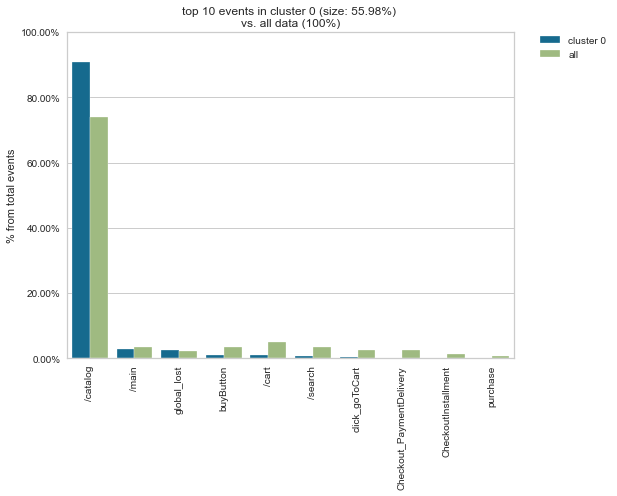

In [32]:
res_rete.rete.cluster_event_dist(0, top_n=10)

**Вопрос 2**
Какие различия вы можете заметить между получившимися группами пользователей? Дайте качественную и количественную оценку.
Разницы в частотах встречаемости событий? Разница в вероятности конверсии в покупку? Что-нибудь ещё?

**Ответ:**
1. В соотношении событий purchase и global_lost видно явное преобладание потерянных пользователей
2. Наибольшую результативность показывают 4 и 5 кластеры, несмотря на их небольшое количество в сравнении с другими. Внути обоих кластеров поведение пользователейц схожее, однако в 5 видна явная зависимость purchase и Checkout_PaymentDelivery
3. Наименее конверсионный кластер - 0. Переходов между событиями хдесь гораздо меньше, в основном использовалась стрраница каталога.
4. Различия видны не только в частоте событий, конверсии, но и в поведении пользователей и их количестве.

In [33]:
res_rete['timestamp'] = pd.to_datetime(res_rete['timestamp'])
res_rete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110133 entries, 71967 to 10376
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   client_id   110133 non-null  uint64        
 1   session     110133 non-null  object        
 2   timestamp   110133 non-null  datetime64[ns]
 3   event       110133 non-null  object        
 4   next_event  110133 non-null  object        
 5   global_idx  110133 non-null  int32         
 6   client_idx  110133 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(3), uint64(1)
memory usage: 6.3+ MB


In [34]:
data = res_rete[['timestamp', 'client_id', 'session', 'event']]
data.head()

,timestamp,client_id,session,event
71967,2020-01-26 17:10:45,640282419644438,6402824196444381580058645,/main
71968,2020-01-26 17:28:12,640282419644438,6402824196444381580059692,/main
71969,2020-01-26 19:37:48,640282419644438,6402824196444381580058645,/catalog
71970,2020-01-26 20:04:53,640282419644438,6402824196444381580059392,/main
71971,2020-01-26 21:59:16,640282419644438,6402824196444381580058645,/catalog


In [35]:
def visualize_all_data(df):
    data = df.copy()
    
    min_date = data['timestamp'].min()
    max_date = data['timestamp'].max()
    #неделя события с начала наблюдений
    data['delta'] = (data['timestamp'] - min_date).apply(lambda x: np.floor(x.days/7))

    #найдем для пользоваателей их даты присоединения:
    g_data = data.groupby('client_id').min().reset_index()
    #колонка delta - неделя присоединения с начала наблюдения:
    g_data['delta'] = (g_data['timestamp'] - min_date).apply(lambda x: np.floor(x.days/7))

    sns.set(style='white', context='notebook', rc={'figure.figsize':(8,5)})
    bin_num=int(np.floor((max_date-min_date).days/7))
    
    sns.distplot(data['delta'], kde=False,bins=bin_num, norm_hist=True, label='')
    sns.distplot(g_data['delta'], kde=False,bins=bin_num, norm_hist=True, label='')
    plt.xlabel('Недели с начала наблюдения')

    plt.legend(labels=["Все события в эту неделю","Пользователи, пришедшие в эту неделю"])
    plt.show()
    print('начало наблюдения: '+ str(min_date))

C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


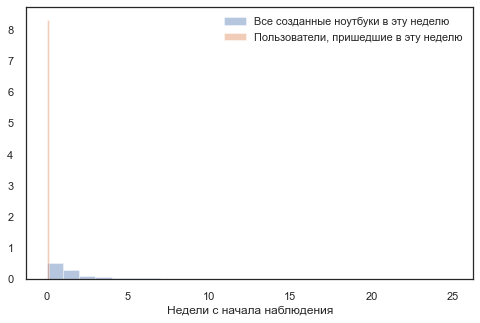

начало наблюдения: 2020-01-24 21:01:58


In [36]:
visualize_all_data(data)

In [42]:
#размер когорты (в этом примере этот параметр будет также использоваться как величина периода для наблюдений за когортой)
cohort_size = 5
#интервал времени между когортами для сравнения
interval_between_cohorts = 2

#найдем для пользователей их даты присоединения:
g_data = data.groupby('client_id')['timestamp'].first().reset_index()
#колонка delta - день присоединения с начала наблюдения:
g_data['delta'] = (g_data['timestamp'] - data['timestamp'].min()).apply(lambda x: x.days)


#получим айдишники  пользователей присоединившихся в первую неделю и во вторую:
cohort_1_users = g_data[g_data['delta']<cohort_size]['client_id'].unique()
cohort_2_users = g_data.loc[(g_data['delta']>=interval_between_cohorts) &
                            (g_data['delta']<interval_between_cohorts+cohort_size)]['client_id'].unique()

#полные логи событий для каждой из когорт:
data_c1 = data[data['client_id'].isin(cohort_1_users)].copy()
data_c2 = data[data['client_id'].isin(cohort_2_users)].copy()

In [43]:
def visualize_users(df):
    data = df.copy()
    min_date = data['timestamp'].min()

    g_data = data.groupby('client_id').min().reset_index()
    g_data['delta'] = (g_data['timestamp'] - min_date).apply(lambda x: x.days/7)

    sns.set(style='white', context='notebook', rc={'figure.figsize':(8,5)})

    sns.distplot(g_data['delta'], kde=False,bins=2, norm_hist=False, label='')
    plt.xlabel('Недели с начала наблюдения когортой')

    plt.legend(labels=["Пользователи, пришедшие в эту неделю"])
    plt.xlim([0,53])
    plt.show()
    print('начало наблюдения за когортой: '+ str(min_date))

def visualize_purchases(df):
    data = df.copy()
    min_date = data['timestamp'].min()
    max_date = data['timestamp'].max()

    data['delta'] = (data['timestamp'] - min_date).apply(lambda x: np.floor(x.days/7))


    sns.set(style='white', context='notebook', rc={'figure.figsize':(8,5)})
    bin_num=int(np.floor((max_date-min_date).days/7))
    
    sns.distplot(data['delta'], kde=False,bins=bin_num, norm_hist=False, label='')
    plt.xlabel('Недели с начала наблюдения за когортой')

    plt.legend(labels=["Все события в эту неделю"])
    plt.xlim([0,53])
    plt.show()
    print('начало наблюдения за когортой: '+ str(min_date))
    
def visualize_scripts(df):
    data = df.copy()
    min_date = data['timestamp'].min()

    g_data = data.groupby('ScriptId').min().reset_index()
    g_data['delta'] = (g_data['timestamp'] - min_date).apply(lambda x: x.days/7)

    sns.set(style='white', context='notebook', rc={'figure.figsize':(8,5)})

    sns.distplot(g_data['delta'], kde=False,bins=2, norm_hist=False, label='')
    plt.xlabel('Недели с начала наблюдения когортой')

    plt.legend(labels=["События"])
    plt.xlim([0,53])
    plt.show()
    print('начало наблюдения за когортой: '+ str(min_date))

C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


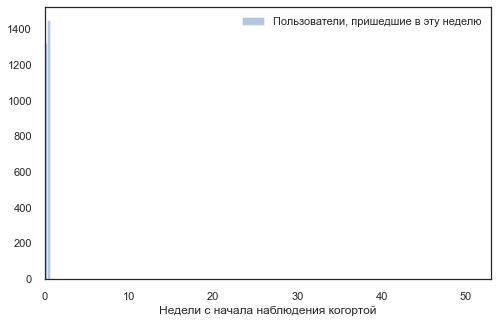

начало наблюдения за когортой: 2020-01-24 21:01:58


In [44]:
visualize_users(data_c1)

C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


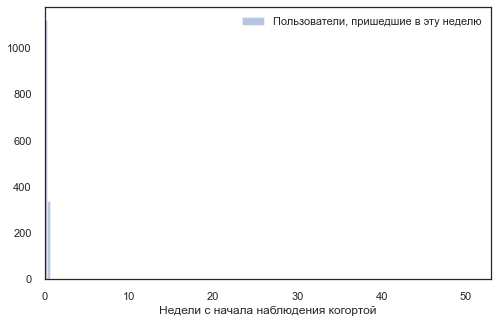

начало наблюдения за когортой: 2020-01-26 21:15:05


In [45]:
 visualize_users(data_c2)

In [46]:
data_c1['client_id'].nunique(), data_c2['client_id'].nunique()

(2770, 1460)

In [47]:
data_c1['session'].nunique(), data_c2['session'].nunique()

(8789, 3928)

C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


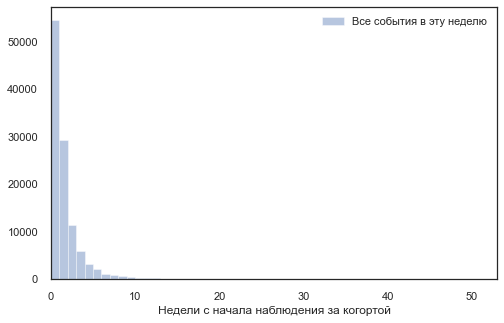

начало наблюдения за когортой: 2020-01-24 21:01:58


In [48]:
visualize_purchases(data_c1)

C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


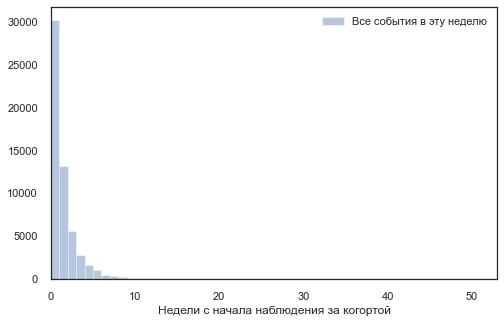

начало наблюдения за когортой: 2020-01-26 21:15:05


In [49]:
visualize_purchases(data_c2)

In [51]:
#рассчитаем номер периода (в данном случае 14 дней) в который произошло событие относительно каждой когорты
data_c1['delta'] = (data_c1['timestamp'] - data_c1['timestamp'].min())\
                    .apply(lambda x: np.floor(x.days / cohort_size))

data_c2['delta'] = (data_c2['timestamp'] - data_c2['timestamp'].min())\
                    .apply(lambda x: np.floor(x.days / cohort_size))

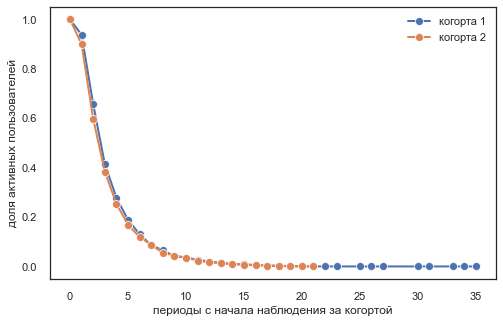

In [52]:
#количество уникальных клиентов для каждой когорты в каждый период
retention_c1 =  data_c1.groupby('delta')['client_id'].apply(lambda x: len(set(x)))
retention_c2 =  data_c2.groupby('delta')['client_id'].apply(lambda x: len(set(x)))

sns.lineplot(x = retention_c1.index, y = retention_c1.values/max(retention_c1.values),
             lw = 2, marker="o", markersize = 8)

sns.lineplot(x = retention_c2.index, y = retention_c2.values/max(retention_c2.values),
             lw = 2, marker="o", markersize = 8)

plt.xlabel('периоды с начала наблюдения за когортой')
plt.ylabel('доля активных пользователей')

plt.legend(labels=["когорта 1","когорта 2"])
plt.show()

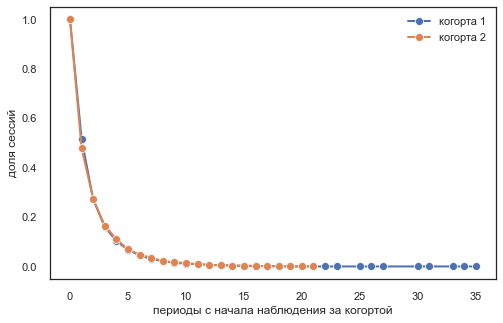

In [53]:
#количество скриптов для каждой когорты в каждый период
script_c1 =  data_c1.groupby('delta')['session'].apply(lambda x: len(set(x)))
script_c2 =  data_c2.groupby('delta')['session'].apply(lambda x: len(set(x)))

sns.lineplot(x = script_c1.index, y = script_c1.values/max(script_c1.values),
             lw = 2, marker="o", markersize = 8)

sns.lineplot(x = script_c2.index, y = script_c2.values/max(script_c2.values),
             lw = 2, marker="o", markersize = 8)

plt.xlabel('периоды с начала наблюдения за когортой')
plt.ylabel('доля сессий')

plt.legend(labels=["когорта 1","когорта 2"])
plt.show()

**Вопрос 3**
Можете ли вы придумать дополнительные признаки для построения предсказательной модели? Если да, проверьте их влияние на конечный performance.
* Кажется, можно использовать метки кластеров для добавления дополнительной информации. Может, что-нибудь ещё?

**Ответ:**
В качестве альтернативного подхода можно выделить когорты на основе разделения пользователей по времени. В этом случае поведение пользователей совпадает, анализ по сессиям также схож. Если использовать эти данные для дальнейшего предсказания поведения пользователей, прогноз окажется ошибочным.

## Some predictions here

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score

lr = LogisticRegression()
rf = RandomForestClassifier(random_state=42,n_estimators=500)
ada = AdaBoostClassifier(n_estimators=100)

### lr

In [57]:
cross_val_score(lr,X,y,scoring='accuracy').mean()

0.905900863704332

In [58]:
y

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [59]:
cross_val_score(lr,X,y,scoring='roc_auc').mean()

0.688319030738004

In [60]:
cross_val_score(lr,X,y,scoring='precision').mean()

C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and

0.0

In [61]:
cross_val_score(lr,X,y,scoring='recall').mean()

0.0

### rf

In [62]:
cross_val_score(rf,X,y,scoring='accuracy').mean()

0.8931744295906145

In [63]:
cross_val_score(rf,X,y,scoring='roc_auc').mean()

0.6350938157438722

In [64]:
cross_val_score(rf,X,y,scoring='precision').mean()

0.09714285714285713

In [65]:
cross_val_score(rf,X,y,scoring='recall').mean()

0.01641156462585034

### ada

In [66]:
cross_val_score(ada,X,y,scoring='accuracy').mean()

0.8935649935649936

In [67]:
cross_val_score(ada,X,y,scoring='roc_auc').mean()

0.5898488029812479

In [68]:
cross_val_score(ada,X,y,scoring='precision').mean()

0.16297619047619047

In [69]:
cross_val_score(ada,X,y,scoring='recall').mean()

0.02457482993197279

**Вопрос 4**
Какую метрику вы выберете для предсказаний? Обоснуйте ответ.
ROC-AUC, accuracy, precision, recall, F1-score. Почему accuracy однозначно НЕ подходит?

**Ответ:**
* accuracу - доля правильных ответов алгоритма, однако модель совершенно не обладает никакой предсказательной силой
* **roc_auc** - оценивает модель в целом и показывает, случайно ли предсказание (если больше 0,5 - есть закономерности, чем ближе к 1, тем они точнее)
* precision - точность, т.е. доля объектов, названных классификатором положительными и при этом действительно являющимися положительными
* recall - полнота, т.е. доля объектов положительного класса из всех объектов положительного класса
* F-мера - среднее гармоническое precision и recall. F-мера достигает максимума при полноте и точности, равными единице, и близка к нулю, если один из аргументов близок к нулю

Вывод: метрика roc_auc

## Методы в sklearn

### Стекинг
Ансамблевый метод - используется несколько разнородных слабых учеников. Их обучают и объединяют для построения прогноза, основанного на результатах различных слабых моделей

In [70]:
from sklearn.ensemble import StackingClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

data, target = load_breast_cancer(return_X_y=True)

estimators = [('lr', LogisticRegression()), ('dt', DecisionTreeClassifier())]
modelClf = StackingClassifier(estimators=estimators, final_estimator=SVC())

X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.3, random_state=12)

modelClf.fit(X_train, y_train)
print(modelClf.score(X_valid, y_valid))

0.935672514619883


C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modul

### Бэггинг
Ансамблевый метод - В этом случае однородные модели обучают на разных наборах данных и объединяют. Получают прогноз путём усреднения. Если использовать в качестве слабого ученика деревья решений, то получится случайный лес RandomForestClassifier / RandomForestRegressor

In [71]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier

data, target = load_breast_cancer(return_X_y=True)

modelClf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=50, random_state=12)

X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.3, random_state=12)

modelClf.fit(X_train, y_train)
print(modelClf.score(X_valid, y_valid))

C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modul

0.9239766081871345


C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modul

### Бустинг
Ансамблевый метод - Метод бустинга в чём то схож с методом бэггинга: берётся множество одинаковых моделей и объединяется, чтобы получить сильного ученика. Но разница заключается в том, что модели приспосабливаются к данным последовательно, то есть каждая модель будет исправлять ошибки предыдущей

In [72]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

data, target = load_breast_cancer(return_X_y=True)

modelClf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=12)

X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.3, random_state=12)

modelClf.fit(X_train, y_train)
print(modelClf.score(X_valid, y_valid))

0.9415204678362573


**Вопрос 5**
Какая модель в итоге дала лучший результат? Предложите гипотезу, почему именно она.
* Линейные или нелинейные? Ансамблевые методы, решающие деревья, опорные векторы и регрессия. Всё можно найти в sklearn, попробуйте разные и сравните их результаты

**Ответ:**
Лучший результат показала модель линейной регрессии (roc_auc = 0.68).  Остальные методы предполагают более сложные задачи. Для решения проблемы классификации набора данных наиболее подходящими алгоритмами машинного обучения являются: метод k-ближайших соседей, метод опорных векторов и экстра-деревья. Однако текущая задача предполагает простое предсказание, конвертируются пользователи или нет, то лучше использовать линейную регрессию.

В качестве дополнительного примера расчета взяла Ансамблевые модели: стекинг, бэггинг, бустинг.

**Вопрос 6** 
Какие события сильнее всего влияют на конверсию? Можете ли вы их выделить?

**Ответ:**
Из анализа графов выше можно увидеть топ-10 событий наиболее конвертируемых кластеров 
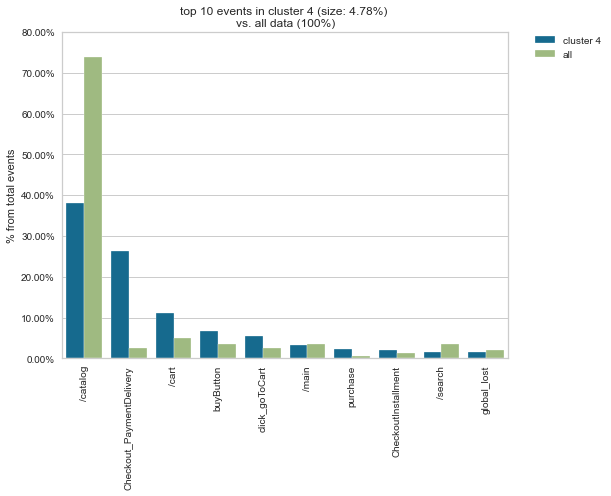

Однако для полноценного анализа конверсии необходимо больше данных, в том числе по стоимости и количеству преобретаемых товаров/услуг